In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [2]:
# Setup plot defaultrialsrialsrialss
import matplotlib.pyplot as plt
import seaborn as sns

# Reset styling to default
plt.rcdefaults()
# Grid on
plt.rcParams['axes.grid'] = True
# Top and right axis spines off
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Title 18 x y labels 16 ticks 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
fig_w=6
fig_h=6
plt.rcParams['figure.figsize'] = (fig_w,fig_h )
# Make axis equal
#plt.rcParams['axes.axisbelow'] = True 


plt.rcParams['grid.color'] = '0.8'# Grid color

# Set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#043908', '#ff7f0e', '#9467bd', '#d62728', '#364704', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
# Set default grid settings
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['font.family'] = 'sans-serif'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 70

In [ ]:
#load data
dataName="_bimodal_audioVisual_durEst_2025-03-25_19h15.28.386.csv"
"_bimodal_audioVisual_durEst_2025-03-20_18h29.39.932.csv"

data = pd.read_csv("dataBimodal/"+dataName)
data[:4]
data

,Unnamed: 0,standardDur,riseDur,order,preDur,postDur,isiDur,trial_num,totalDur,delta_dur_percents,...,stair_is_reversal,response_keys,conflictDur,recordedOnsetVisualStandard,recordedOffsetVisualStandard,recordedDurVisualStandard,recordedOnsetAudioTest,recordedOffsetAudioTest,recordedDurAudioTest,modalityPostCueTest
0,0,0.5011,0.0,1,0.4426,0.4176,0.0251,0,2.3384,0.9,...,False,left,0.0,0.429773,1.380144,0.950371,1.413537,1.913056,0.499519,NaN
1,1,0.5011,0.0,1,0.4927,0.5178,0.1169,1,2.5805,0.9,...,False,left,0.0,0.477413,1.427220,0.949808,1.543996,2.044059,0.500063,NaN
2,2,0.5011,0.0,1,0.5762,0.4426,0.0752,2,2.5471,0.9,...,False,left,0.0,0.563134,1.513607,0.950473,1.588128,2.088705,0.500576,NaN
3,3,0.5011,0.0,1,0.4176,0.4927,0.2338,3,2.5972,0.9,...,False,right,0.0,0.406585,1.356553,0.949967,1.598317,2.098444,0.500127,NaN


In [6]:
from scipy.stats import norm
from scipy.optimize import minimize

# Define Psychometric Function and Optimization

In [7]:

def psychometric_function(intensities, lapse_rate, mu, sigma):
    # Cumulative distribution function with mean mu and standard deviation sigma
    cdf = norm.cdf(intensities, loc=mu, scale=sigma) 
    # take into account of lapse rate and return the probability of choosing test
    return lapse_rate * 0.5 + (1 - lapse_rate) * cdf 

def derivative_psychometric_function(intensities, lapse_rate, mu, sigma):
    #F'(x) = (1-lambda)*(1(/sqrt(2*pi)sigma)exp((x-mu)^2/sigma^2)

    return (1 - lapse_rate) * (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-((intensities - mu) ** 2) / (2 * sigma ** 2))    

# Negative log-likelihood
def negative_log_likelihood(params, delta_dur, chose_test, totalResp):
    lambda_, mu, sigma = params # Unpack parameters
    p = psychometric_function(delta_dur, lambda_, mu, sigma) # Compute probability of choosing test
    epsilon = 1e-9 # Add a small number to avoid log(0) when calculating the log-likelihood
    p = np.clip(p, epsilon, 1 - epsilon) # Clip p to avoid log(0) and log(1)
    # Compute the negative log-likelihood
    log_likelihood = np.sum(chose_test * np.log(p) + (totalResp - chose_test) * np.log(1 - p))
    return -log_likelihood

# Fit psychometric function
def fit_psychometric_function(levels,nResp, totalResp,init_guesses=[0,0,0]):

    # then fits the psychometric function
    #initial_guess = [0, -0.2, 0.05]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0, 0.2), (-0.4, +0.4), (0.05, 1)]  # Reasonable bounds
  #  bounds=[[0,-0.8,0.05],[0.06,0.8,1]]
    # fitting is done here
    result = minimize(
        negative_log_likelihood, x0=init_guesses, 
        args=(levels, nResp, totalResp),
        bounds=bounds,
        method='Nelder-Mead'
    )
    # returns the fitted parameters lambda, mu, sigma
    return result.x

# Compute sigma from slope
def compute_sigma_from_slope(slope, lapse_rate=0.02):
    sigma = (1 - lapse_rate) / (np.sqrt(2 * np.pi) * slope)*np.exp(-0.5)
    return sigma


#  Raw psychometric

In [8]:
def rawNegLogLike(params, level, response):
    # Unpack parameters
    lapse_rate, mu, sigma = params
    # Compute the probability of choosing test
    p = psychometric_function(level, lapse_rate, mu, sigma)
    # Add a small number to avoid log(0)
    epsilon = 1e-9
    p = np.clip(p, epsilon, 1 - epsilon)
    # Compute the negative log-likelihood
    log_likelihood = np.sum(response * np.log(p) + (1 - response) * np.log(1 - p))
    return -log_likelihood

# Fit psychometric function
def fitPsychometricRaw(levels, response,init_guesses=[0,0,0]):
    #initial_guess = [0, -0.2, 0.05]  # Initial guess for [lambda, mu, sigma]
    bounds = [(0, 0.2), (-0.4, +0.4), (0.05, 1)]  # Reasonable bounds
  #  bounds=[[0,-0.8,0.05],[0.06,0.8,1]]
    # fitting is done here
    result = minimize(
        rawNegLogLike, x0=init_guesses, 
        args=(levels, response),
        bounds=bounds,
        method='Nelder-Mead'
    )
    # returns the fitted parameters lambda, mu, sigma
    return result.x


# Group data

In [9]:
# Define columns for chosing test or standard
data['chose_test'] = (data['responses'] == data['order']).astype(int)
data['chose_standard'] = (data['responses'] != data['order']).astype(int)
try:
    print(data["rise_dur"]>1)
except:
    data["rise_dur"]=1

data['standard_dur']=data['standardDur']

def groupByChooseTest(x):
    grouped = x.groupby(['delta_dur_percents', 'rise_dur', 'standard_dur']).agg(
        num_of_chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count'),
        num_of_chose_standard=('chose_standard', 'sum')
    ).reset_index()
    grouped['p_choose_test'] = grouped['num_of_chose_test'] / grouped['total_responses']

    return grouped

def groupByStandardDur(x):
    grouped = x.groupby(['delta_dur_percents', 'rise_dur', 'standard_dur']).agg(
        num_of_chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count'),
        num_of_chose_standard=('chose_standard', 'sum')
    ).reset_index()
    grouped['pChooseStandard'] = grouped['num_of_chose_standard'] / grouped['total_responses']

    return grouped

grouped=groupByChooseTest(data)
# p_choose_test
#sort the group
grouped = grouped.sort_values([ 'standard_dur'])

# Estimate initial parameters

In [10]:
from scipy.stats import linregress
def estimate_initial_guesses(levels,chooseTest,totalResp, max_sigma_ratio=0.2):
    """
    Estimate initial guesses for lambda, mu, and sigma with slope adjustment and sigma regularization.
    """
    intensities = levels
    chose_test = chooseTest
    total_resp = totalResp
    
    # Compute proportion of "chose test"
    proportions = chose_test / total_resp
    
    # Perform linear regression to estimate slope and intercept
    slope, intercept, _, _, _ = linregress(intensities, proportions)
    mu_guess = (0.5 - intercept) / slope

    #print(slope, intercept)
    lapse_rate_guess= 0.03  # 5% as a reasonable guess
    sigma_guess= compute_sigma_from_slope(slope,lapse_rate_guess)-0.1

    # Regularize sigma to avoid overestimation
    intensity_range = np.abs(max(intensities)) - np.abs(min(intensities))
    max_sigma = intensity_range * max_sigma_ratio
    #sigma_guess = min(sigma_guess, max_sigma)
    #sigma_guess=sigma_guess/3
    
    return [lapse_rate_guess, mu_guess, sigma_guess]
estimate_initial_guesses(grouped['delta_dur_percents'],grouped['num_of_chose_test'],grouped['total_responses'])

def estimateInitialGuessesRaw(levels,responses,maxSigmaRatio=0.2):
    """
    Estimate initial guesses for lambda, mu, and sigma with slope adjustment and sigma regularization.
    """
    # Compute proportion of "chose test"
    proportions = responses / levels
    
    # Perform linear regression to estimate slope and intercept
    slope, intercept, _, _, _ = linregress(levels, proportions)
    mu_guess = (0.5 - intercept) / slope

    #print(slope, intercept)
    lapse_rate_guess= 0.03  # 5% as a reasonable guess
    sigma_guess= compute_sigma_from_slope(slope,lapse_rate_guess)-0.1

    # Regularize sigma to avoid overestimation
    intensity_range = np.abs(max(levels)) - np.abs(min(levels))
    max_sigma = intensity_range * maxSigmaRatio
    sigma_guess = min(sigma_guess, max_sigma)
    #sigma_guess=sigma_guess/3
    
    return [lapse_rate_guess, mu_guess, sigma_guess]


# 1 by 1 Psychometric Function fitting

In [11]:
conflictLeves=sorted(data['conflictDur'].unique())
standardDurLevels=sorted(data['standardDur'].unique())
noiseLevels=sorted(data['rise_dur'].unique())
print(f"Standard duration levels: {standardDurLevels}, Conflict levels: {conflictLeves}, Noise levels: {noiseLevels}")

Standard duration levels: [0.5011], Conflict levels: [0.0], Noise levels: [1]


Standard duration: 0.5011, Noise level: 1, Conflict level: 0.0, Fitted parameters: [0.2       0.3392026 1.       ]


/var/folders/_p/yywkspd92qs_6p63bz38bswr0000gn/T/ipykernel_20117/1888938989.py:19: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(


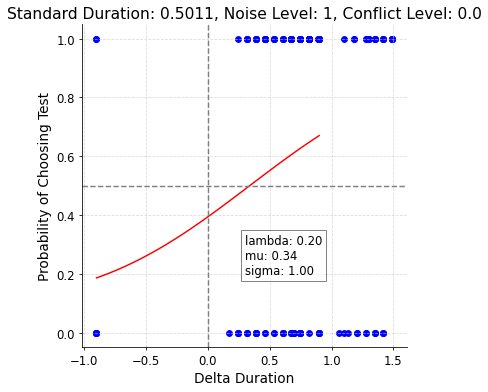

In [12]:
for i, standardLevel in enumerate(standardDurLevels):
    for j, noiseLevel in enumerate(noiseLevels):
        for k, conflictLevel in enumerate(conflictLeves):        
            #filter data
            df=data[data['conflictDur']==conflictLevel]
            df= df[df["standardDur"]==standardLevel]
            df=df[df["rise_dur"]==noiseLevel]

            # select levels
            levels=df['delta_dur_percents'].values
            responses=df['chose_test'].values
            # estimate initial guesses
            initial_guesses = estimateInitialGuessesRaw(levels, responses)
               
            # fit psychometric function
            fitted_params = fitPsychometricRaw(levels, responses,initial_guesses)
            # print fitted parameters
            print(f"Standard duration: {standardLevel}, Noise level: {noiseLevel}, Conflict level: {conflictLevel}, Fitted parameters: {fitted_params}")

            # plot psychometric function
            plt.figure()
            plt.scatter(levels, responses, label='Data', color='blue')
            x = np.linspace(-0.9, 0.9, 100)
            y = psychometric_function(x, *fitted_params)
            plt.plot(x, y, label='Psychometric Function', color='red')
            plt.axvline(x=0, color='gray', linestyle='--',)
            plt.axhline(y=0.5, color='gray', linestyle='--')
            plt.xlabel('Delta Duration')
            plt.ylabel('Probability of Choosing Test')
            plt.title(f'Standard Duration: {standardLevel}, Noise Level: {noiseLevel}, Conflict Level: {conflictLevel}')
            # add fitted parameters to the plot
            plt.text(0.3, 0.2, f'lambda: {fitted_params[0]:.2f}\nmu: {fitted_params[1]:.2f}\nsigma: {fitted_params[2]:.2f}', fontsize=12, 
                     bbox=dict(facecolor='white', alpha=0.5))

            # # Binned data
            # binSize=8 # number of bins
            # binEdges = np.linspace(-0.9, 0.9, binSize + 1)
            # binCenters = 0.5 * (binEdges[:-1] + binEdges[1:])
            # binnedResponses = np.zeros(binSize)
            # binnedCounts = np.zeros(binSize)
            # for i in range(binSize):
            #     binMask = (levels >= binEdges[i]) & (levels < binEdges[i + 1])
            #     binnedResponses[i] = np.sum(responses[binMask])
            #     binnedCounts[i] = np.sum(binMask)
            # binnedProportions = binnedResponses / binnedCounts
            # # Plot each binCenter individually with marker size based on the number of responses
            # for binCenter, proportion, count in zip(binCenters, binnedProportions, binnedCounts):
            #     marker_size = (count / totalResponses + 0.5) * 100  # Adjust marker size based on count
            #     plt.scatter(binCenter, proportion, s=marker_size, color='green', label='Binned Data' if binCenter == binCenters[0] else "")
            # plt.legend()



            

# Aggregate data and fit psychometric function

Standard (Visual)duration: 0.5011, Noise level: 1, Conflict level: 0.0, Fitted parameters: [0.2 0.4 1. ]


/var/folders/_p/yywkspd92qs_6p63bz38bswr0000gn/T/ipykernel_20117/3768991739.py:30: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(


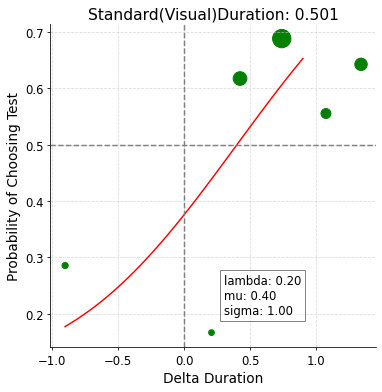

In [21]:
for i, standardLevel in enumerate(standardDurLevels):
    for j, noiseLevel in enumerate(noiseLevels):
        for k, conflictLevel in enumerate(conflictLeves):        
            #filter data
            df=data[data['conflictDur']==conflictLevel]
            df= df[df["standardDur"]==standardLevel]
            df=df[df["rise_dur"]==noiseLevel]

            grouped=groupByChooseTest(df)
            # p_choose_test
            levels=grouped['delta_dur_percents'].values
            responses=grouped['num_of_chose_test'].values
            totalResponses=grouped['total_responses'].values
            # estimate initial guesses
            initial_guesses = estimate_initial_guesses(levels, responses, totalResponses)
            # fit psychometric function
            fitted_params = fit_psychometric_function(levels, responses, totalResponses,initial_guesses)
            # print fitted parameters
            print(f"Standard (Visual)duration: {standardLevel}, Noise level: {noiseLevel}, Conflict level: {conflictLevel}, Fitted parameters: {fitted_params}")

            # plot psychometric function
            plt.figure()
            #plt.scatter(levels, responses/totalResponses, label='Data', color='blue')
            x = np.linspace(-0.9, 0.9, 100)
            y = psychometric_function(x, *fitted_params)
            plt.plot(x, y, label='Psychometric Function', color='red')
            plt.axvline(x=0, color='gray', linestyle='--',)
            plt.axhline(y=0.5, color='gray', linestyle='--')
            plt.xlabel('Delta Duration')
            plt.ylabel('Probability of Choosing Test')
            plt.title(f'Standard(Visual)Duration: {round(standardLevel,3)}')
            # add fitted parameters to the plot
            plt.text(0.3, 0.2, f'lambda: {fitted_params[0]:.2f}\nmu: {fitted_params[1]:.2f}\nsigma: {fitted_params[2]:.2f}', fontsize=12, 
                     bbox=dict(facecolor='white', alpha=0.5))
            
            # Bin using pd.cut
            binSize=8 # number of bins
            grouped['bin'] = pd.cut(grouped['delta_dur_percents'], bins=binSize,
                                    labels=False, include_lowest=True,retbins=False)
            #calculate means and sums for each bin
            binGroup=grouped.groupby('bin').agg(
                mean_delta_dur=('delta_dur_percents', 'mean'),
                sum_num_of_chose_test=('num_of_chose_test', 'sum'),
                sum_total_responses=('total_responses', 'sum')
            ).reset_index()
            #total responses for normalization of marker size
            totalResponses=grouped['total_responses'].sum()
            #calculate proportions
            binGroup['pChooseTest'] = binGroup['sum_num_of_chose_test'] / binGroup['sum_total_responses']
            #plot binned data
            plt.scatter(binGroup['mean_delta_dur'], binGroup['pChooseTest'], label='Binned Data', color='green'
                        ,s=binGroup['sum_total_responses']/totalResponses*900)
            
